### Created on 2025
### @author: S.W

# CIFAR-10 Transfer Learning with PyTorch
이 튜토리얼에서는 초심자를 위해 단계별로 PyTorch로 CIFAR-10 데이터를 불러오고, VGG16 사전학습 모델을 활용해 전이학습(Transfer Learning)하는 과정을 설명합니다.

## 1. 분석에 필요한 패키지 불러오기

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# GPU 사용 가능 시 자동 선택
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


- torch, torchvision: 딥러닝 라이브러리
- sklearn: 데이터 분할, 평가 지표
- device: 모델/연산을 CPU와 GPU 중에서 선택

## 2. CIFAR-10 데이터 로드 및 NumPy 변환

In [2]:
# 2.1 torchvision CIFAR-10 dataset 불러오기 (train + test)
raw_tf = transforms.Compose([transforms.ToTensor()])
cifar_train = datasets.CIFAR10(root='./data', train=True,  download=True, transform=raw_tf)
cifar_test  = datasets.CIFAR10(root='./data', train=False, download=True, transform=raw_tf)

# 2.2 NumPy 배열로 변환 함수 정의
def to_numpy(dataset):
    X, y = [], []
    for img, label in dataset:
        X.append(img.numpy())
        y.append(label)
    return np.stack(X), np.array(y)

X_train, y_train = to_numpy(cifar_train)
X_test,  y_test  = to_numpy(cifar_test)

print('Train shapes:', X_train.shape, y_train.shape)
print('Test shapes :', X_test.shape,  y_test.shape)

Files already downloaded and verified
Files already downloaded and verified
Train shapes: (50000, 3, 32, 32) (50000,)
Test shapes : (10000, 3, 32, 32) (10000,)


- CIFAR10(..., transform=ToTensor())는 (H,W,C) 이미지를 (C,H,W) 텐서로 변환합니다.
- to_numpy 함수로 PyTorch 텐서를 NumPy 배열로 바꿉니다.

## 3. 데이터 결합 및 Train/Test 재분할

In [3]:
# 3.1 배열 합치기
X = np.concatenate([X_train, X_test], axis=0)
y = np.concatenate([y_train, y_test], axis=0)
print('Combined shapes:', X.shape, y.shape)

# 3.2 sklearn train_test_split로 subset 만들기
indices = np.arange(len(X))
train_idx, test_idx = train_test_split(
    indices, train_size=0.1, test_size=0.02,
    stratify=y, random_state=42
)
print('Sample counts:', len(train_idx), len(test_idx))

Combined shapes: (60000, 3, 32, 32) (60000,)
Sample counts: 6000 1200


- train_size=0.1, test_size=0.02로 각각 10%, 2% 데이터 선정
- stratify=y로 클래스 비율 유지

## 4. PyTorch Dataset & DataLoader 준비

In [4]:
from torch.utils.data import Dataset, Subset

class NumpyDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X, self.y, self.transform = X, y, transform
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        img = (self.X[idx].transpose(1,2,0)*255).astype(np.uint8)
        img = Image.fromarray(img)
        if self.transform: img = self.transform(img)
        return img, self.y[idx]

# 4.1 증강 정의
train_tf = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(32, scale=(0.8,1.0)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,)*3, (0.5,)*3)
])
test_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,)*3, (0.5,)*3)
])

# 4.2 Subset & DataLoader 생성
full_ds = NumpyDataset(X, y, transform=None)
train_ds = Subset(full_ds, train_idx)
test_ds  = Subset(full_ds, test_idx)
# transform 할당
train_ds.dataset.transform = train_tf
test_ds.dataset.transform  = test_tf

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=2)
test_loader  = DataLoader(test_ds,  batch_size=64, shuffle=False,num_workers=2)

print('First train batch:', next(iter(train_loader))[0].shape)

First train batch: torch.Size([64, 3, 32, 32])


- NumpyDataset는 NumPy 데이터를 PIL Image로 변환 후 증강
- 마지막 print로 배치 크기 확인: (64,3,32,32)

## 5. VGG16 기반 전이학습 모델 정의

In [5]:
# 5.1 사전학습 VGG16 로드
backbone = models.vgg16(pretrained=True)

# 5.2 TransferModel 정의
class TransferModel(nn.Module):
    def __init__(self, backbone):
        super().__init__()
        self.features = backbone.features
        self.avgpool  = nn.AdaptiveAvgPool2d((1,1))
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512,500),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(500,10),
            nn.Sigmoid()
        )
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        return self.classifier(x)

model = TransferModel(backbone).to(device)
print(model)

/home/crocus/anaconda3/envs/keri_test/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/crocus/anaconda3/envs/keri_test/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


TransferModel(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, 

- AdaptiveAvgPool2d((1,1))로 1×1 공간 크기 풀링
- Linear(512,500) → ReLU → Dropout → Linear(500,10) → Sigmoid

## 6. 학습 설정 및 루프

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 50
train_losses, val_losses = [], []
train_accs,  val_accs    = [], []

for epoch in range(num_epochs):
    # (1) 학습 모드
    model.train()
    total_loss, preds, trues = 0, [], []
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        out = model(imgs)
        loss = criterion(out, labels)
        loss.backward(); optimizer.step()

        total_loss += loss.item() * imgs.size(0)
        preds.append(out.argmax(1).cpu().numpy())
        trues.append(labels.cpu().numpy())

    train_loss = total_loss/len(train_loader.dataset)
    train_acc  = accuracy_score(np.concatenate(trues), np.concatenate(preds))

    # (2) 평가 모드\ model.eval()
    total_loss, preds, trues = 0, [], []
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            out = model(imgs)
            loss = criterion(out, labels)
            total_loss += loss.item()*imgs.size(0)
            preds.append(out.argmax(1).cpu().numpy())
            trues.append(labels.cpu().numpy())

    val_loss = total_loss/len(test_loader.dataset)
    val_acc  = accuracy_score(np.concatenate(trues), np.concatenate(preds))

    train_losses.append(train_loss); val_losses.append(val_loss)
    train_accs.append(train_acc);   val_accs.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs}: "
          f"Train {train_loss:.4f}/{train_acc:.4f} "
          f"Val {val_loss:.4f}/{val_acc:.4f}")

Epoch 1/50: Train 1.8834/0.4582 Val 1.7993/0.5567
Epoch 2/50: Train 1.7159/0.6418 Val 1.7318/0.6400
Epoch 3/50: Train 1.6619/0.7207 Val 1.6552/0.7600
Epoch 4/50: Train 1.6141/0.7965 Val 1.6687/0.7408
Epoch 5/50: Train 1.5893/0.8260 Val 1.6437/0.7775
Epoch 6/50: Train 1.5623/0.8657 Val 1.6258/0.7892
Epoch 7/50: Train 1.5432/0.8902 Val 1.6324/0.7792
Epoch 8/50: Train 1.5303/0.9073 Val 1.6172/0.8117
Epoch 9/50: Train 1.5160/0.9290 Val 1.6049/0.8217
Epoch 10/50: Train 1.5167/0.9295 Val 1.6063/0.8258
Epoch 11/50: Train 1.5033/0.9470 Val 1.6139/0.8108
Epoch 12/50: Train 1.5018/0.9495 Val 1.6349/0.7850
Epoch 13/50: Train 1.5047/0.9427 Val 1.6266/0.8033
Epoch 14/50: Train 1.4932/0.9593 Val 1.6179/0.8050
Epoch 15/50: Train 1.4853/0.9752 Val 1.6182/0.8233
Epoch 16/50: Train 1.4833/0.9753 Val 1.6488/0.7867
Epoch 17/50: Train 1.4935/0.9592 Val 1.6290/0.8008
Epoch 18/50: Train 1.4934/0.9622 Val 1.6246/0.8067
Epoch 19/50: Train 1.4883/0.9680 Val 1.6295/0.7983
Epoch 20/50: Train 1.4871/0.9703 Val 1.6

- model.train() vs model.eval() 모드를 명확히 분리
- 배치별 손실 누적 후 평균 계산, accuracy_score로 정확도 측정

## 7. 결과 시각화 및 최종 평가

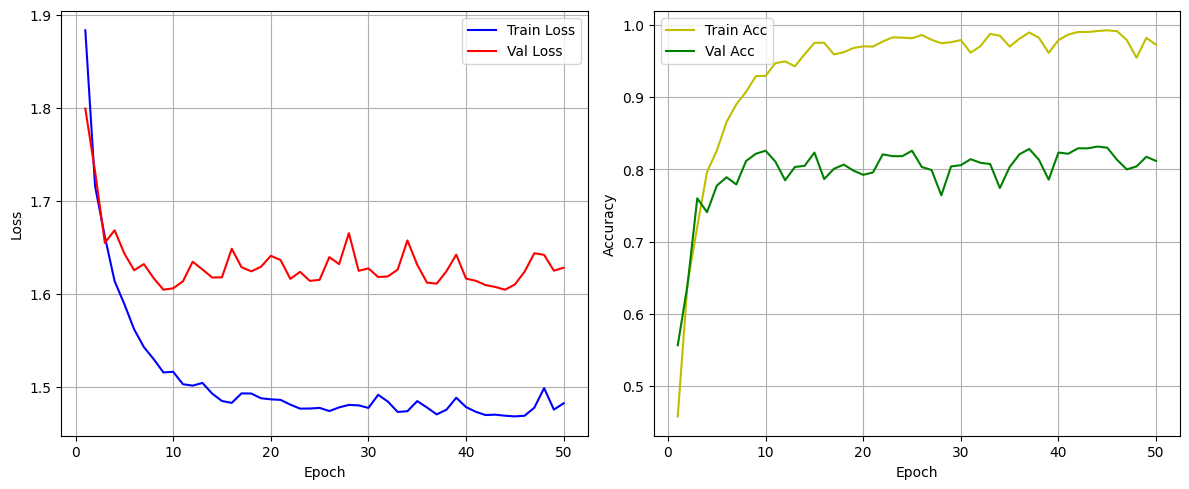

Test Accuracy: 0.8125


In [7]:
# 학습 곡선 그리기
epochs = range(1, num_epochs+1)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs, train_losses, 'b-', label='Train Loss')
plt.plot(epochs, val_losses, 'r-', label='Val Loss')
plt.legend(); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.grid()

plt.subplot(1,2,2)
plt.plot(epochs, train_accs, 'y-', label='Train Acc')
plt.plot(epochs, val_accs, 'g-', label='Val Acc')
plt.legend(); plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.grid()
plt.tight_layout(); plt.show()

# 테스트 정확도
all_preds, all_trues = [], []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        out = model(imgs)
        all_preds.append(out.argmax(1).cpu().numpy())
        all_trues.append(labels.numpy())
all_preds = np.concatenate(all_preds)
all_trues = np.concatenate(all_trues)
print('Test Accuracy:', accuracy_score(all_trues, all_preds))

- 손실/정확도 곡선으로 학습 경향 확인
- 테스트 세트의 최종 정확도 출력

In [8]:
# 7) 테스트 세트 예측 및 accuracy_score
all_preds, all_trues = [], []
model.eval()
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        all_preds.append(outputs.argmax(dim=1).cpu().numpy())
        all_trues.append(labels.numpy())
all_preds = np.concatenate(all_preds)
all_trues = np.concatenate(all_trues)
print('Test accuracy:', accuracy_score(all_trues, all_preds))

Test accuracy: 0.8141666666666667
